# CISC 451/839 Topics in Data Analytics 
## Course Project - Using Feature Engineering and Supervised Learning to Predict Game Results in Professional Hockey 
### Gavin McClelland - 10211444 
### Marshall Cunningham - 20249991

TODO: Fix this description

The objectives of this notebook are as follows: 
- Build on top of the previous approaches included in the midterm submission which featured extensive EDA and simple model construction to justify the validity of the project (not trivial to understand/predict game results if information about the score is omitted)
- Using performance trends from previous games, aim to develop models to predict the result of a game before it happens
    - we are only concerned with the binary classification task of predicting wins and losses, not the condition of victory (such as winning in regulation, overtime, or in a               shootout)

## Contents

The analytics process contained in this notebook is as follows:

1. Read-in Data
2. Create features in the range [0,1]
3. Min-Max normalization
4. Feature selection


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,plot_confusion_matrix,roc_curve,auc
from make_confusion_matrix import make_confusion_matrix
from plot_roc_curve import plot_roc_curve
from validate_model import validate_model
%cd "C:\Users\gmcclelland\Desktop\Misc School Stuff\repo\CISC451\project\data"
# %cd "<Your Working Directory Here>"
%matplotlib inline

C:\Users\gmcclelland\Desktop\Misc School Stuff\repo\CISC451\project\data


In [2]:
# Importing datasets, from the previous snapshot of work done for the midterm submission, and more sophisticated information from moneypuck.com 
team_stats = pd.read_csv('game_teams_stats.csv')
game_stats = pd.read_csv("all_teams.csv")

In [3]:
# For confusion matrix and roc viz
group_names = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Loss", "Win"]

In [4]:
game_stats.drop(game_stats[game_stats['season'] < 2010].index, inplace=True)
game_stats.drop(game_stats[game_stats['playoffGame'] == 1].index, inplace=True)
game_stats.drop(game_stats[game_stats['situation'] != 'all'].index, inplace=True)

In [5]:
team_stats = team_stats[['game_id', 'HoA', 'won']]
team_stats.rename(
    columns={
        "game_id": "gameId",
        "HoA": "home_or_away",
        "won": "WON"
    }, inplace=True
)
team_stats['home_or_away'] = team_stats['home_or_away'].str.upper()
# Inner join datasets to get an accurate label
game_stats = pd.merge(game_stats, team_stats,how='inner',on=['gameId','home_or_away'])

# Code the WON and home_or_away columns into integers
game_stats['WON'] = np.where(game_stats['WON'] == True, 1, 0)
game_stats['home_or_away'] = np.where(game_stats['home_or_away'] == 'HOME', 1, 0)

game_stats.groupby('home_or_away').size()

home_or_away
0    10748
1    10536
dtype: int64

In [6]:
game_stats.groupby('WON').size()

WON
0    10652
1    10632
dtype: int64

In [7]:
game_stats.shape

(21284, 112)

In [8]:
games = game_stats.groupby(['gameId','home_or_away','WON']).size().reset_index().rename(columns={0:'count'})
# Find all games that have both teams either wining or losing
duplicate_games = games.loc[games['count'] > 1]

In [9]:
duplicate_games

,gameId,home_or_away,WON,count
2568,2011020055,0,0,2
2611,2011020077,0,1,2
2636,2011020090,0,1,2
2695,2011020120,0,1,2
2724,2011020135,0,0,2
...,...,...,...,...
8489,2013021116,0,1,2
8532,2013021138,0,1,2
8571,2013021158,0,1,2
8690,2013021218,0,1,2


In [10]:
# Remove duplicates
game_stats.drop(game_stats.loc[game_stats.gameId.isin(duplicate_games.gameId.values)].index, inplace=True)
game_stats.groupby('WON').size()

WON
0    10536
1    10536
dtype: int64

In [11]:
game_stats.drop(columns=['name',
                        'playerTeam',
                        'opposingTeam',
                        'gameDate',
                        'position',
                        'situation',
                        'iceTime',
                        'playoffGame'], inplace=True)                     
game_stats.head()

,team,season,gameId,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalFor,xGoalsFor,xReboundsFor,...,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,WON
0,NYR,2010,2010020013,0,0.6494,0.4724,0.4545,29.597,4.448,1.721,...,48.0,43.710,7.0,0.463,0.239,0.239,2.624,2.417,2.382,1
1,NYR,2010,2010020028,0,0.4394,0.5526,0.5488,32.763,3.099,2.388,...,37.0,36.554,5.0,0.425,0.600,0.600,3.777,3.736,3.482,0
2,NYR,2010,2010020049,1,0.4434,0.4602,0.4787,31.758,2.306,2.242,...,49.0,50.910,4.0,0.602,0.137,0.137,3.360,3.465,3.368,0
3,NYR,2010,2010020070,1,0.3698,0.5772,0.5217,34.411,2.784,2.691,...,44.0,45.647,2.0,0.512,1.674,1.674,3.582,3.683,3.655,0
4,NYR,2010,2010020083,0,0.4983,0.4622,0.5584,30.732,2.313,1.828,...,34.0,32.080,7.0,0.414,0.373,0.373,2.370,2.266,2.167,1


In [12]:
# most features have a 'for' and 'against' pair, so we will combine them into a ratio in the range 0:1, which adds additional context to the game (i.e. which team had more shots on goal, etc.)
entries = []
for column in game_stats.columns.tolist():
    if column[-3:] == 'For':
        entries.append(column[:-3])
# NOTE: This took awhile to figure out, but if the stat has '0' in the for AND against columns, then the ratio will be null. If this is the case, we assign a ratio of 0.5 to each team with that gameId which provides a neutral, non-zero weight
for x in entries:
    game_stats[f'{x}Ratio'] = game_stats.apply(lambda row: row[f'{x}For'] / (row[f'{x}For'] + row[f'{x}Against']) if (row[f'{x}For'] + row[f'{x}Against']) != 0 else 0.5, axis=1)
    game_stats.drop(columns=[f'{x}For',f'{x}Against'],inplace=True)

In [13]:
# note that many of the probabalistic statistics (such as xGoalsPercentage) are not always a direct indicator of success. Teams with an xGoalsPercentage less than 50% still win games (roughly 20%)
game_stats.loc[(game_stats.xGoalsPercentage < 0.5) & (game_stats.WON == 1)].shape[0]

3884

In [14]:
cols_to_normalize = game_stats.drop(columns=['team','gameId','home_or_away','WON','season']).columns.tolist()
# Min-Max Normalization
for column in cols_to_normalize:
        game_stats[column] = (game_stats[column] - game_stats[column].min()) / (game_stats[column].max() - game_stats[column].min())
game_stats

,team,season,gameId,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,WON,xOnGoalRatio,xGoalsRatio,...,scoreAdjustedShotsAttemptsRatio,unblockedShotAttemptsRatio,scoreAdjustedUnblockedShotAttemptsRatio,dZoneGiveawaysRatio,xGoalsFromxReboundsOfShotsRatio,xGoalsFromActualReboundsOfShotsRatio,reboundxGoalsRatio,totalShotCreditRatio,scoreAdjustedTotalShotCreditRatio,scoreFlurryAdjustedTotalShotCreditRatio
0,NYR,2010,2010020013,0,0.679610,0.452821,0.419838,1,0.437720,0.679653,...,0.543949,0.419913,0.503240,0.222222,0.415238,0.794143,0.794143,0.629203,0.674970,0.679200
1,NYR,2010,2010020028,0,0.427146,0.589915,0.585976,0,0.593086,0.427207,...,0.607790,0.585947,0.597294,0.500000,0.589866,0.219766,0.219766,0.471463,0.483117,0.502276
2,NYR,2010,2010020049,1,0.431955,0.431966,0.462474,0,0.467786,0.431927,...,0.402453,0.462513,0.437262,0.555556,0.410938,0.697572,0.697572,0.399349,0.379376,0.381349
3,NYR,2010,2010020070,1,0.343472,0.631966,0.538231,0,0.530825,0.343498,...,0.601680,0.538302,0.506312,0.500000,0.563743,0.275325,0.275325,0.413137,0.394788,0.385632
4,NYR,2010,2010020083,0,0.497956,0.435385,0.602889,1,0.608103,0.497928,...,0.498877,0.602968,0.658119,0.416667,0.465865,0.478322,0.478322,0.497203,0.536795,0.548200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21279,L.A,2018,2018021214,1,0.605795,0.358803,0.338971,1,0.349344,0.605813,...,0.316348,0.338966,0.305388,0.714286,0.424312,1.000000,1.000000,0.502974,0.466172,0.465320
21280,L.A,2018,2018021228,1,0.455157,0.460855,0.448203,0,0.437154,0.455217,...,0.379050,0.448179,0.378689,0.384615,0.476290,0.485697,0.485697,0.446950,0.395078,0.387280
21281,L.A,2018,2018021238,0,0.371964,0.264444,0.188513,1,0.216059,0.371991,...,0.283344,0.188552,0.219036,0.272727,0.117852,0.217143,0.217143,0.371023,0.391002,0.393276
21282,L.A,2018,2018021256,0,0.427987,0.639145,0.672833,0,0.683458,0.427999,...,0.637314,0.672897,0.670017,0.416667,0.736430,0.411921,0.411921,0.487788,0.496646,0.496658


In [15]:
# rearranging columns to beginning of df for organization purposes
cols = game_stats.drop(columns=['WON']).columns.tolist()
cols = ['WON'] + cols
game_stats = game_stats.reindex(columns=cols)
game_stats.head()

,WON,team,season,gameId,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalRatio,xGoalsRatio,...,scoreAdjustedShotsAttemptsRatio,unblockedShotAttemptsRatio,scoreAdjustedUnblockedShotAttemptsRatio,dZoneGiveawaysRatio,xGoalsFromxReboundsOfShotsRatio,xGoalsFromActualReboundsOfShotsRatio,reboundxGoalsRatio,totalShotCreditRatio,scoreAdjustedTotalShotCreditRatio,scoreFlurryAdjustedTotalShotCreditRatio
0,1,NYR,2010,2010020013,0,0.679610,0.452821,0.419838,0.437720,0.679653,...,0.543949,0.419913,0.503240,0.222222,0.415238,0.794143,0.794143,0.629203,0.674970,0.679200
1,0,NYR,2010,2010020028,0,0.427146,0.589915,0.585976,0.593086,0.427207,...,0.607790,0.585947,0.597294,0.500000,0.589866,0.219766,0.219766,0.471463,0.483117,0.502276
2,0,NYR,2010,2010020049,1,0.431955,0.431966,0.462474,0.467786,0.431927,...,0.402453,0.462513,0.437262,0.555556,0.410938,0.697572,0.697572,0.399349,0.379376,0.381349
3,0,NYR,2010,2010020070,1,0.343472,0.631966,0.538231,0.530825,0.343498,...,0.601680,0.538302,0.506312,0.500000,0.563743,0.275325,0.275325,0.413137,0.394788,0.385632
4,1,NYR,2010,2010020083,0,0.497956,0.435385,0.602889,0.608103,0.497928,...,0.498877,0.602968,0.658119,0.416667,0.465865,0.478322,0.478322,0.497203,0.536795,0.548200


## Approach #1 - Predicting the outcome using advanced statistics from the game (with no knowledge of the opponent)

### Feature Selection
We already have quite a few features (55), so before looking at previous games to predict the result of a game before it happens, let's find out which of these features are of any significance

In [16]:
gs_cpy = game_stats.copy()
game_stats.columns.tolist()

['WON',
 'team',
 'season',
 'gameId',
 'home_or_away',
 'xGoalsPercentage',
 'corsiPercentage',
 'fenwickPercentage',
 'xOnGoalRatio',
 'xGoalsRatio',
 'xReboundsRatio',
 'xFreezeRatio',
 'xPlayStoppedRatio',
 'xPlayContinuedInZoneRatio',
 'xPlayContinuedOutsideZoneRatio',
 'flurryAdjustedxGoalsRatio',
 'scoreVenueAdjustedxGoalsRatio',
 'flurryScoreVenueAdjustedxGoalsRatio',
 'shotsOnGoalRatio',
 'missedShotsRatio',
 'blockedShotAttemptsRatio',
 'shotAttemptsRatio',
 'goalsRatio',
 'reboundsRatio',
 'reboundGoalsRatio',
 'freezeRatio',
 'playStoppedRatio',
 'playContinuedInZoneRatio',
 'playContinuedOutsideZoneRatio',
 'savedShotsOnGoalRatio',
 'savedUnblockedShotAttemptsRatio',
 'penaltiesRatio',
 'penalityMinutesRatio',
 'faceOffsWonRatio',
 'hitsRatio',
 'takeawaysRatio',
 'giveawaysRatio',
 'lowDangerShotsRatio',
 'mediumDangerShotsRatio',
 'highDangerShotsRatio',
 'lowDangerxGoalsRatio',
 'mediumDangerxGoalsRatio',
 'highDangerxGoalsRatio',
 'lowDangerGoalsRatio',
 'mediumDangerG

### Feature Importance
Fitting a simple logistic regression model to our features to resolve feature "importances"

In [17]:
# Dropping categorical features, and also dropping goalsRatio, which explicitly represents the goals scored by each team
X = game_stats.drop(columns=['team','gameId','season','goalsRatio','WON']) 
Y = game_stats['WON']

In [18]:
lr = LogisticRegression()
lr.fit(X,Y)

LogisticRegression()

In [19]:
np.abs(lr.coef_[0])

array([ 1.30067998,  1.14947851,  0.40772228,  3.15203373,  1.64871398,
        1.14930468,  2.40177143,  3.08730117,  0.29300966,  0.79503016,
        6.19467885,  1.48468111,  1.03705138,  3.66050981,  8.49545978,
        3.69922804,  3.14921015,  0.41048741,  0.07241704,  0.87096748,
        3.04421264,  0.61384293,  6.87492843,  5.32691102, 15.66374217,
       14.1866723 ,  0.13297455,  0.78056003,  0.11741237,  0.28144897,
        0.24926202,  0.10171299,  1.86593555,  0.26980632,  0.11462508,
        1.91491363,  2.641267  ,  0.61996486,  4.25167025,  4.20884003,
        3.10096184,  5.21708261,  3.15325813,  7.69295171,  0.0671291 ,
        3.06895097,  0.29923454,  0.50998097,  0.04915655,  2.42605623,
        4.44555488])

Below, we plot our feature coefficients in descending order to observe where a drop-off occurs

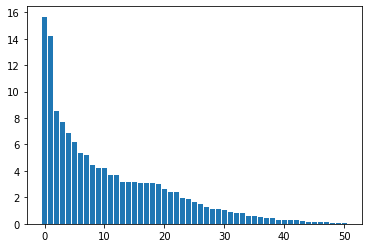

In [20]:
importance = np.abs(lr.coef_[0])
sorted_importance = -np.sort(-importance)
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(sorted_importance))], sorted_importance)
plt.show()

From the plot above, we are choosing the top 19 features as there is an observable drop-off in performance afterwards

Next, we find our columns to drop from our dataset, so we are left with our 19 most important features

In [21]:
cols_to_drop = []
thresh = sorted_importance[18]
for n,val in enumerate(importance):
    print(val)
    if val < thresh:
        cols_to_drop.append(game_stats.columns[n+4])
game_stats.drop(cols_to_drop,axis=1,inplace=True)

1.300679979253326
1.1494785144229598
0.40772228349505446
3.1520337255221698
1.6487139824116965
1.149304675453365
2.4017714304653213
3.0873011708704405
0.293009656753454
0.7950301629443306
6.194678851049144
1.4846811140311573
1.0370513764511289
3.6605098107327803
8.495459784404872
3.6992280363393184
3.1492101498037743
0.410487414927188
0.07241703927382163
0.8709674765757347
3.0442126407033894
0.6138429279779819
6.874928430440959
5.326911022165617
15.663742172367337
14.186672298899346
0.13297455017178078
0.7805600279267647
0.11741237491660245
0.2814489675492729
0.24926201774889323
0.10171298926996661
1.865935550022819
0.26980632491692746
0.1146250815592999
1.9149136260241886
2.641266996560694
0.6199648582306234
4.251670249401393
4.208840029894478
3.1009618365318974
5.217082606095728
3.153258131662515
7.692951710602552
0.06712910154599269
3.06895096643505
0.29923454262203364
0.5099809722015298
0.04915654712883549
2.4260562251422844
4.445554879145968


In [22]:
# Verifying that feature selection worked as expected
print(cols_to_drop)

['home_or_away', 'xGoalsPercentage', 'corsiPercentage', 'xOnGoalRatio', 'xGoalsRatio', 'xReboundsRatio', 'xPlayStoppedRatio', 'xPlayContinuedInZoneRatio', 'flurryAdjustedxGoalsRatio', 'scoreVenueAdjustedxGoalsRatio', 'shotAttemptsRatio', 'goalsRatio', 'reboundsRatio', 'reboundGoalsRatio', 'freezeRatio', 'savedUnblockedShotAttemptsRatio', 'penaltiesRatio', 'penalityMinutesRatio', 'faceOffsWonRatio', 'hitsRatio', 'takeawaysRatio', 'giveawaysRatio', 'lowDangerShotsRatio', 'mediumDangerShotsRatio', 'highDangerShotsRatio', 'lowDangerxGoalsRatio', 'mediumDangerxGoalsRatio', 'scoreAdjustedUnblockedShotAttemptsRatio', 'xGoalsFromxReboundsOfShotsRatio', 'xGoalsFromActualReboundsOfShotsRatio', 'reboundxGoalsRatio', 'totalShotCreditRatio']


Next, we create a correlation heatmap to visualize any redundant/synonymous features, along with those that are too highly correlated with the outcome label 'WON'

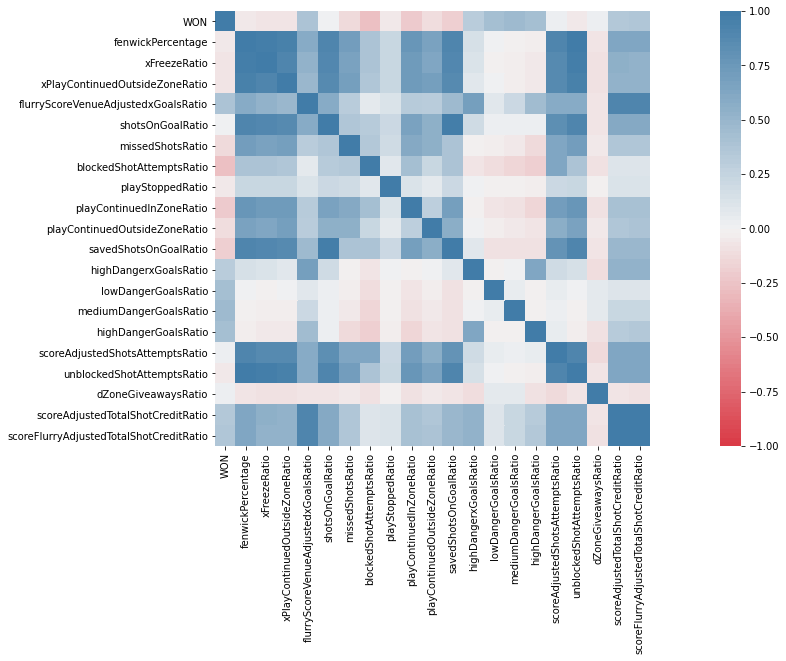

In [23]:
corr = game_stats.drop(columns=['team','gameId','season']).corr()
fig, ax = plt.subplots(figsize=(25,8)) 
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1,
    square=True,
    cmap=sns.diverging_palette(10,240,n=100),
    ax=ax
)

The only duplicate features are different versions of the same stat, which can be seen near the bottom (different versions of shotCredit)
- So, we keep the flurry adjusted stat as flurry is more repeatable and regarded as having more predictive power (see report)

In [24]:
game_stats.drop(columns=['scoreAdjustedTotalShotCreditRatio'],inplace=True)

In [25]:
# dimensions of the dataset after selecting features
game_stats.shape

(21072, 23)

In [26]:
from sklearn import svm
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import accuracy_score
feat = game_stats.drop(columns=['team','gameId','WON'])
label = game_stats['WON']
# Train on 2010 - 2017, test on 2018
x_train = feat.loc[feat.season < 2018].drop(columns=['season'])
x_test = feat.loc[feat.season == 2018].drop(columns=['season'])
y_train = game_stats.loc[game_stats.season < 2018]['WON'].drop(columns=['season'])
y_test = game_stats.loc[game_stats.season == 2018]['WON'].drop(columns=['season'])
# x_train,x_test,y_train,y_test = train_test_split(feat,label,test_size=0.2) # test on 20% of dataset 
# Using a random forest classifier as a benchmark
clf = RandomForestClassifier()
scores = cross_validate(clf, x_train, y_train, scoring='accuracy',cv=10,return_estimator=True)

In [27]:
best_score = np.argmax(scores['test_score'])
estimators = scores['estimator']
clf = estimators[best_score]
pred = clf.predict(x_test)
accuracy_score(y_test,pred)

0.9331235247836349

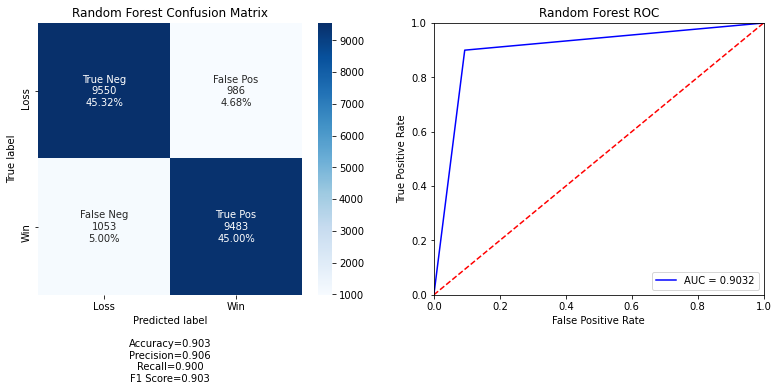

<Figure size 432x288 with 0 Axes>

In [28]:
validate_model(clf,feat,label,'Random Forest', group_names=group_names, categories=categories)

In [29]:
lrc = LogisticRegression()
knnc = KNeighborsClassifier() # defaults to 5-NN
dtc = DecisionTreeClassifier()
svm = svm.SVC(kernel='linear', C=1)

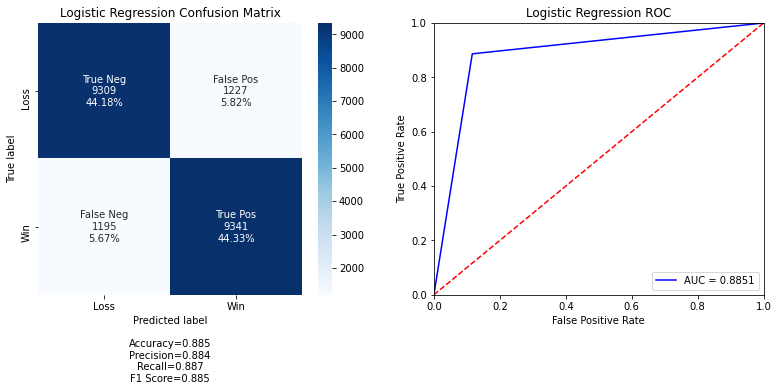

<Figure size 432x288 with 0 Axes>

In [30]:
validate_model(lrc, feat, label, 'Logistic Regression', group_names=group_names, categories=categories)

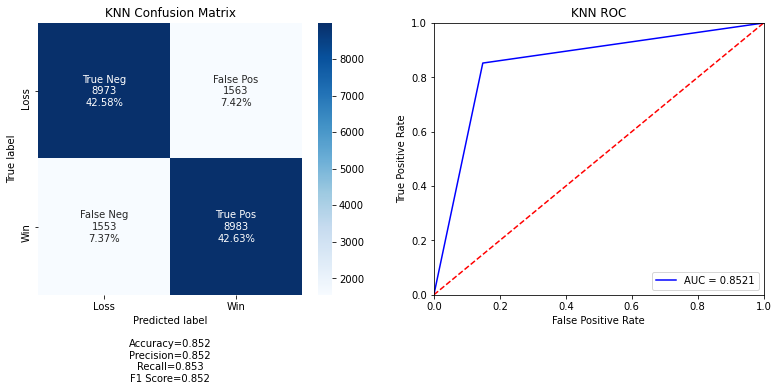

<Figure size 432x288 with 0 Axes>

In [31]:
validate_model(knnc, feat, label, 'KNN', group_names=group_names, categories=categories)

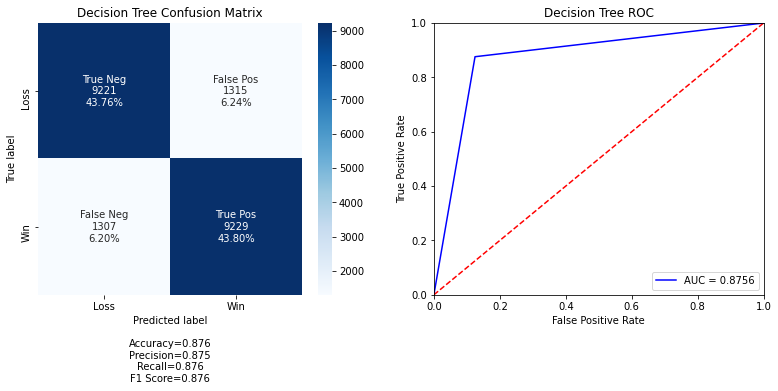

<Figure size 432x288 with 0 Axes>

In [32]:
validate_model(dtc, feat, label, 'Decision Tree', group_names=group_names, categories=categories)

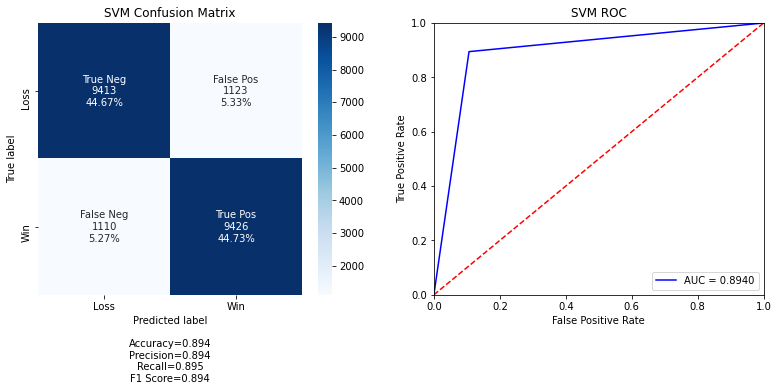

<Figure size 432x288 with 0 Axes>

In [33]:
validate_model(svm, feat, label, 'SVM', group_names=group_names, categories=categories)

## Approach #2: Creating Historical Features (again, with no knowledge of the opponent)
With the objective of predicting outcome before a game has occurred, it is important to have information about the team **before** the game takes place
- So, below we create rolling averages from the previous 1, and 3 games not including the current game. This will create historical versions of the previously selected features for training our models

In [34]:
gs_cpy # using the deep copy of the dataframe created prior to feature selection in approach #1

,WON,team,season,gameId,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalRatio,xGoalsRatio,...,scoreAdjustedShotsAttemptsRatio,unblockedShotAttemptsRatio,scoreAdjustedUnblockedShotAttemptsRatio,dZoneGiveawaysRatio,xGoalsFromxReboundsOfShotsRatio,xGoalsFromActualReboundsOfShotsRatio,reboundxGoalsRatio,totalShotCreditRatio,scoreAdjustedTotalShotCreditRatio,scoreFlurryAdjustedTotalShotCreditRatio
0,1,NYR,2010,2010020013,0,0.679610,0.452821,0.419838,0.437720,0.679653,...,0.543949,0.419913,0.503240,0.222222,0.415238,0.794143,0.794143,0.629203,0.674970,0.679200
1,0,NYR,2010,2010020028,0,0.427146,0.589915,0.585976,0.593086,0.427207,...,0.607790,0.585947,0.597294,0.500000,0.589866,0.219766,0.219766,0.471463,0.483117,0.502276
2,0,NYR,2010,2010020049,1,0.431955,0.431966,0.462474,0.467786,0.431927,...,0.402453,0.462513,0.437262,0.555556,0.410938,0.697572,0.697572,0.399349,0.379376,0.381349
3,0,NYR,2010,2010020070,1,0.343472,0.631966,0.538231,0.530825,0.343498,...,0.601680,0.538302,0.506312,0.500000,0.563743,0.275325,0.275325,0.413137,0.394788,0.385632
4,1,NYR,2010,2010020083,0,0.497956,0.435385,0.602889,0.608103,0.497928,...,0.498877,0.602968,0.658119,0.416667,0.465865,0.478322,0.478322,0.497203,0.536795,0.548200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21279,1,L.A,2018,2018021214,1,0.605795,0.358803,0.338971,0.349344,0.605813,...,0.316348,0.338966,0.305388,0.714286,0.424312,1.000000,1.000000,0.502974,0.466172,0.465320
21280,0,L.A,2018,2018021228,1,0.455157,0.460855,0.448203,0.437154,0.455217,...,0.379050,0.448179,0.378689,0.384615,0.476290,0.485697,0.485697,0.446950,0.395078,0.387280
21281,1,L.A,2018,2018021238,0,0.371964,0.264444,0.188513,0.216059,0.371991,...,0.283344,0.188552,0.219036,0.272727,0.117852,0.217143,0.217143,0.371023,0.391002,0.393276
21282,0,L.A,2018,2018021256,0,0.427987,0.639145,0.672833,0.683458,0.427999,...,0.637314,0.672897,0.670017,0.416667,0.736430,0.411921,0.411921,0.487788,0.496646,0.496658


In [35]:
window_lengths = (1, 3, 5, 10)
new_cols = ['team','home_or_away','gameId','season']
# Programatically create column names for empty dataframe which will be appended to later
for col in gs_cpy.columns:
    if col in new_cols:
        continue
    if col == 'WON':
        new_cols.append(col)
    for length in window_lengths:
        new_cols.append(f'{col}Prev{length}')
# Create empty dataframe to store new features as they are created
new_df = pd.DataFrame(columns=new_cols)
# Treat each season as a seperate dataset for rolling windows
for season in gs_cpy.season.sort_values(ascending=True).unique().tolist():
    season_df = gs_cpy.loc[gs_cpy['season'] == season]
    # Seperate teams so that rolling windows are unique to each team
    for team in gs_cpy.team.sort_values(ascending=True).unique().tolist():
        df = season_df.loc[season_df['team'] == team]
        df.sort_values('gameId', ascending=True, inplace=True)
        for col in df.columns:
            if col != 'WON' and col in new_cols:
                continue
            # Create a rolling average for each window length
            for length in window_lengths:
                # shift one record up so the current game is not included
                df[f'{col}Prev{length}'] = df[col].rolling(length).mean().shift(1) 
            if col != 'WON':
                # Drop the orriginal game level information (except the label)
                df.drop(col, axis=1, inplace=True)
        new_df = pd.concat([new_df, df])
# new_df.sort_values('gameId', ascending=True, inplace=True)

In [36]:
new_df.shape

(21072, 213)

In [37]:
# We need to handle NaN's here by dropping the first five games each team plays so the historical features can take effect
new_df.dropna(inplace=True)

In [38]:
new_df

,team,home_or_away,gameId,season,WON,WONPrev1,WONPrev3,WONPrev5,WONPrev10,xGoalsPercentagePrev1,...,totalShotCreditRatioPrev5,totalShotCreditRatioPrev10,scoreAdjustedTotalShotCreditRatioPrev1,scoreAdjustedTotalShotCreditRatioPrev3,scoreAdjustedTotalShotCreditRatioPrev5,scoreAdjustedTotalShotCreditRatioPrev10,scoreFlurryAdjustedTotalShotCreditRatioPrev1,scoreFlurryAdjustedTotalShotCreditRatioPrev3,scoreFlurryAdjustedTotalShotCreditRatioPrev5,scoreFlurryAdjustedTotalShotCreditRatioPrev10
7003,ANA,1,2010020142,2010,0,1.0,0.666667,0.6,0.4,0.356576,...,0.378833,0.358088,0.454064,0.331472,0.395068,0.361903,0.463169,0.337567,0.397433,0.364791
7004,ANA,0,2010020156,2010,0,0.0,0.333333,0.4,0.4,0.625872,...,0.393602,0.381066,0.588601,0.433744,0.405945,0.382928,0.588295,0.437868,0.408424,0.386034
7005,ANA,1,2010020172,2010,1,0.0,0.333333,0.4,0.4,0.390839,...,0.392859,0.388222,0.425090,0.489252,0.401621,0.388708,0.442827,0.498097,0.408764,0.393091
7006,ANA,1,2010020186,2010,1,1.0,0.333333,0.4,0.5,0.548810,...,0.452731,0.436675,0.524266,0.512652,0.450118,0.434984,0.523601,0.518241,0.456006,0.438023
7007,ANA,1,2010020202,2010,1,1.0,0.666667,0.6,0.5,0.433758,...,0.490503,0.447054,0.407940,0.452432,0.479992,0.446492,0.405452,0.457293,0.484669,0.448078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,WSH,0,2018021190,2018,1,1.0,0.666667,0.6,0.6,0.518514,...,0.477433,0.515895,0.513185,0.426759,0.479413,0.522434,0.507733,0.432060,0.479964,0.522689
14208,WSH,0,2018021206,2018,1,1.0,1.000000,0.6,0.6,0.386271,...,0.472881,0.480862,0.491373,0.459757,0.466199,0.489585,0.488842,0.464022,0.466834,0.489818
14209,WSH,0,2018021221,2018,0,1.0,1.000000,0.8,0.6,0.487136,...,0.450777,0.474546,0.521312,0.508623,0.458593,0.489435,0.525524,0.507366,0.462109,0.489905
14210,WSH,1,2018021246,2018,1,0.0,0.666667,0.8,0.6,0.448305,...,0.452414,0.474298,0.422652,0.478446,0.464647,0.487031,0.426602,0.480323,0.468839,0.487658


In [39]:
cols_to_normalize = new_df.drop(columns=['team','gameId','home_or_away','season','WON']).columns.tolist()
# Normalizing the range of all columns once again using min-max
for column in cols_to_normalize:
    new_df[column] = (new_df[column] - new_df[column].min()) / (new_df[column].max() - new_df[column].min())

In [40]:
new_df

,team,home_or_away,gameId,season,WON,WONPrev1,WONPrev3,WONPrev5,WONPrev10,xGoalsPercentagePrev1,...,totalShotCreditRatioPrev5,totalShotCreditRatioPrev10,scoreAdjustedTotalShotCreditRatioPrev1,scoreAdjustedTotalShotCreditRatioPrev3,scoreAdjustedTotalShotCreditRatioPrev5,scoreAdjustedTotalShotCreditRatioPrev10,scoreFlurryAdjustedTotalShotCreditRatioPrev1,scoreFlurryAdjustedTotalShotCreditRatioPrev3,scoreFlurryAdjustedTotalShotCreditRatioPrev5,scoreFlurryAdjustedTotalShotCreditRatioPrev10
7003,ANA,1,2010020142,2010,0,1.0,0.666667,0.6,0.4,0.356576,...,0.265442,0.136430,0.454064,0.258538,0.313017,0.159124,0.463169,0.269466,0.319612,0.167118
7004,ANA,0,2010020156,2010,0,0.0,0.333333,0.4,0.4,0.625872,...,0.295514,0.194176,0.588601,0.425184,0.334741,0.210342,0.588295,0.433299,0.342143,0.219908
7005,ANA,1,2010020172,2010,1,0.0,0.333333,0.4,0.4,0.390839,...,0.294002,0.212160,0.425090,0.515629,0.326106,0.224424,0.442827,0.531679,0.342841,0.237444
7006,ANA,1,2010020186,2010,1,1.0,0.333333,0.4,0.5,0.548810,...,0.415908,0.333927,0.524266,0.553759,0.422959,0.337156,0.523601,0.564582,0.439686,0.349104
7007,ANA,1,2010020202,2010,1,1.0,0.666667,0.6,0.5,0.433758,...,0.492818,0.360010,0.407940,0.455634,0.482621,0.365189,0.405452,0.465029,0.498444,0.374090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,WSH,0,2018021190,2018,1,1.0,0.666667,0.6,0.6,0.518514,...,0.466206,0.533015,0.513185,0.413802,0.481464,0.550192,0.507733,0.423814,0.488799,0.559502
14208,WSH,0,2018021206,2018,1,1.0,1.000000,0.6,0.6,0.386271,...,0.456937,0.444973,0.491373,0.467570,0.455074,0.470168,0.488842,0.476020,0.461884,0.477818
14209,WSH,0,2018021221,2018,0,1.0,1.000000,0.8,0.6,0.487136,...,0.411931,0.429100,0.521312,0.547194,0.439884,0.469802,0.525524,0.546820,0.452198,0.478034
14210,WSH,1,2018021246,2018,1,0.0,0.666667,0.8,0.6,0.448305,...,0.415263,0.428479,0.422652,0.498021,0.451975,0.463946,0.426602,0.502646,0.465993,0.472449


In [41]:
# Dropping categorical features
X2 = new_df.drop(columns=['team','gameId','season','WON'])
new_df['WON'] = new_df['WON'].astype('int')
Y2 = new_df['WON']

In [42]:
lr2 = LogisticRegression()
lr2.fit(X2,Y2)

LogisticRegression()

In [43]:
np.abs(lr2.coef_[0])

array([0.38020233, 0.08650149, 0.18051855, 0.11913461, 0.32900308,
       0.07780129, 0.00754271, 0.13219839, 0.10244993, 0.01872345,
       0.04228512, 0.01156453, 0.06164827, 0.01618173, 0.01893042,
       0.00753459, 0.15431099, 0.01142233, 0.15331036, 0.22345165,
       0.0462514 , 0.07757787, 0.00735337, 0.13265953, 0.10307899,
       0.36357956, 0.05012325, 0.05900675, 0.06017022, 0.1487718 ,
       0.09093666, 0.30519076, 0.00393975, 0.03796473, 0.18108378,
       0.32433704, 0.58435775, 0.21556173, 0.01980727, 0.03921455,
       0.09355279, 0.39284691, 0.00174008, 0.37651189, 0.6044546 ,
       0.11997773, 0.11285789, 0.08724075, 0.03732658, 0.16285098,
       0.03937441, 0.12562028, 0.05023875, 0.21421454, 0.05050467,
       0.08023709, 0.19214056, 0.04911693, 0.22813277, 0.00428361,
       0.03944846, 0.09807519, 0.04638612, 0.02410081, 0.12767138,
       0.06354186, 0.13251129, 0.18537254, 0.21347206, 0.01902314,
       0.04176508, 0.01140785, 0.06123674, 0.21242174, 0.22288

Once again, we plot our feature coefficients in descending order to observe where a drop-off occurs

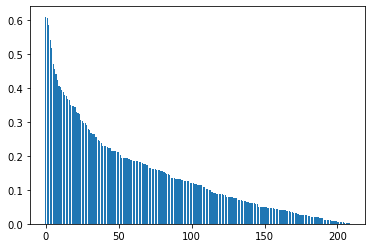

In [44]:
imp2 = np.abs(lr2.coef_[0])
imp2sorted = -np.sort(-imp2)
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(imp2sorted))], imp2sorted)
plt.show()

From the plot above (which looks rather strange), we choose the top 20 features as there is an observable drop-off in performance afterwards

Next, we find our columns to drop from our dataset, so we are left with our 20 most important features

In [45]:
cols_to_drop = []
thresh = imp2sorted[20]
print(f'Threshold: {thresh}')
for n,val in enumerate(imp2):
    if val < thresh:
        print(val)
        cols_to_drop.append(new_df.columns[n+4])
new_df.drop(cols_to_drop,axis=1,inplace=True)

# Verifying that feature selection worked as expected
print(cols_to_drop)

Threshold: 0.342915657650887
0.08650148803832602
0.18051854564007533
0.11913460600055997
0.32900307708219806
0.07780128916993427
0.0075427051669667245
0.13219839069617384
0.10244992603651432
0.01872345484815044
0.04228512137328494
0.011564530793545563
0.061648273677426924
0.01618173013503587
0.018930423840533953
0.007534585098847988
0.15431098938325308
0.011422327460200544
0.15331035671773166
0.22345165245009485
0.04625140317908757
0.07757786971039266
0.007353365997974131
0.1326595301144547
0.10307898927321395
0.05012325330950923
0.059006745573708004
0.060170216966630684
0.14877180186400382
0.0909366614797855
0.30519076323394745
0.00393975031186675
0.03796472713315838
0.18108378275850098
0.3243370377411484
0.2155617269252494
0.019807265710716483
0.03921454977398007
0.09355278562491279
0.0017400769533195213
0.11997773358320692
0.1128578876851725
0.08724074894623815
0.03732658084706898
0.1628509775098
0.03937440635562603
0.12562028202505704
0.05023874763863562
0.21421454004958015
0.05050

And as before, we create a correlation heatmap to visualize any redundant/synonymous features

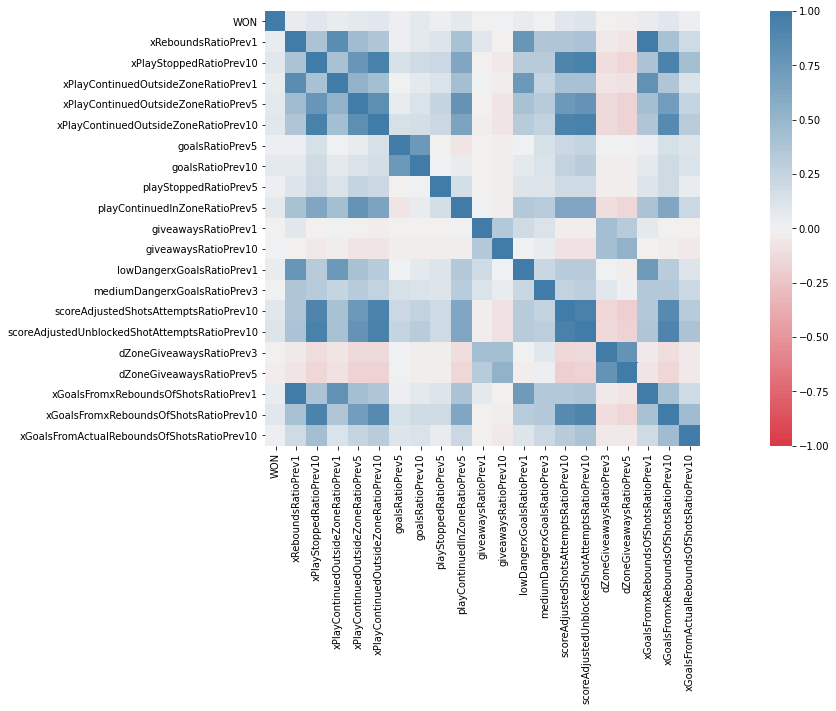

In [46]:
corr = new_df.drop(columns=['team','gameId','season']).corr()
fig, ax = plt.subplots(figsize=(25,8)) 
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1,
    square=True,
    cmap=sns.diverging_palette(10,240,n=100),
    ax=ax
)

In [47]:
# dimensions of the dataset after selecting features
new_df.shape

(18352, 25)

In [48]:
# Cross-validating a simple SVM using an 80/20 training/validation split and 10-fold to find a good estimator
from sklearn import svm
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import accuracy_score
feat = new_df.drop(columns=['team','gameId','WON'])
label = new_df['WON']
# Train on 2010 - 2017, test on 2018
x_train = feat.loc[feat.season < 2018].drop(columns=['season'])
x_test = feat.loc[feat.season == 2018].drop(columns=['season'])
y_train = new_df.loc[new_df.season < 2018]['WON'].drop(columns=['season'])
y_test = new_df.loc[new_df.season == 2018]['WON'].drop(columns=['season'])
# x_train,x_test,y_train,y_test = train_test_split(feat,label,test_size=0.2) # test on 20% of dataset 
clf = svm.SVC(kernel='linear', C=1)
scores = cross_validate(clf, x_train, y_train, scoring='roc_auc',cv=10,return_estimator=True)
scores['test_score']

array([0.54412401, 0.57493581, 0.59579057, 0.58277712, 0.54935533,
       0.57924438, 0.56031378, 0.56852607, 0.56406511, 0.59850593])

In [49]:
# Let's find our best estimator. Since cross_validate returns a dict of estimators and their scores, we can find the index of the estimator containing the best score, and use it to predict against the test set
best_score = np.argmax(scores['test_score'])
estimators = scores['estimator']
clf = estimators[best_score]
pred = clf.predict(x_test)
accuracy_score(y_test,pred)

0.5376344086021505

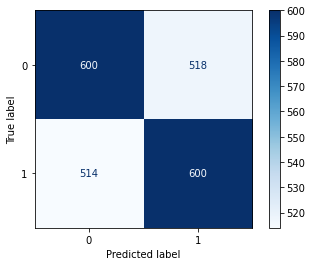

In [50]:
plot_confusion_matrix(clf,x_test,y_test,cmap=plt.cm.Blues)

Well, that's not very good, let's try using PCA and see if performance improves

In [51]:
from sklearn.decomposition import PCA
pca = PCA(n_components=21) # one component for each numerical feature
pca.fit(x_train)
new_data_train = pca.transform(x_train)
new_data_test = pca.transform(x_test)
clf = svm.SVC(kernel='linear', C=1)
scores = cross_validate(clf, new_data_train, y_train, scoring='roc_auc',cv=10,return_estimator=True)
scores['test_score']

array([0.55263648, 0.57867791, 0.59547654, 0.5864792 , 0.55285575,
       0.57725403, 0.56682511, 0.572399  , 0.5637203 , 0.60091651])

In [52]:
new_data_train

array([[ 0.5138376 ,  0.70991994, -0.11114082, ..., -0.04205797,
         0.01633775, -0.00489243],
       [-0.48338707,  0.38975251,  0.30799032, ..., -0.02634115,
         0.01436276, -0.00567488],
       [ 0.51332449,  0.74506042, -0.26019089, ..., -0.02324808,
         0.01055342,  0.01112176],
       ...,
       [-0.49793645,  0.16342373, -0.0476612 , ...,  0.02431932,
         0.01999699,  0.02050053],
       [ 0.50119703,  0.17941796, -0.06448808, ...,  0.0056381 ,
         0.01228468,  0.01108769],
       [ 0.50354524,  0.01360153,  0.16843911, ...,  0.00761906,
         0.01422934,  0.00941182]])

In [53]:
# Let's find our best estimator. Since cross_validate returns a dict of estimators and their scores, we can find the index of the estimator containing the best score, and use it to predict against the test set
best_score = np.argmax(scores['test_score'])
estimators = scores['estimator']
clf = estimators[best_score]
pred = clf.predict(new_data_test)
accuracy_score(y_test,pred)

0.5376344086021505

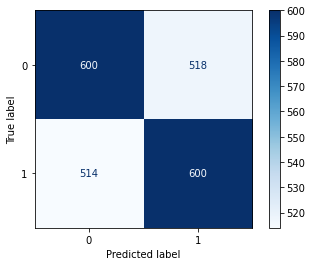

In [54]:
plot_confusion_matrix(clf,new_data_test,y_test,cmap=plt.cm.Blues)

This is still very poor--it's actually even worse--and I'm not sure why (I've tried everything I know how and the accuracy still hovers around 50/50 at best)

Let's see how other classifiers perform; anything around 55% is still pretty good using this type of data

In [55]:
lrc = LogisticRegression()
knnc = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

group_names = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Lost", "Won"]

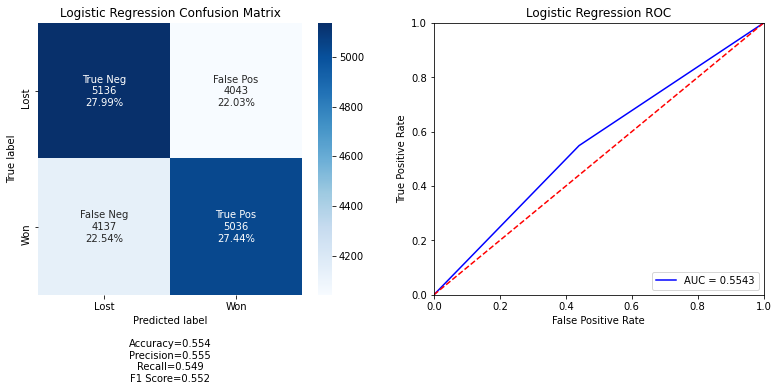

<Figure size 432x288 with 0 Axes>

In [56]:
validate_model(lrc, feat, label, 'Logistic Regression', group_names=group_names, categories=categories)

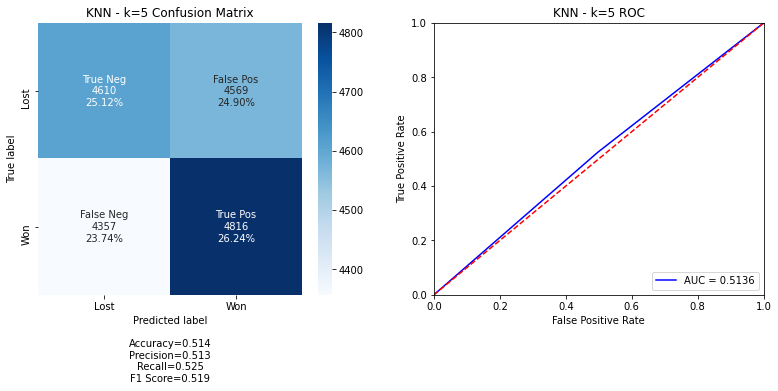

<Figure size 432x288 with 0 Axes>

In [57]:
validate_model(knnc, feat, label, 'KNN - k=5', group_names=group_names, categories=categories)

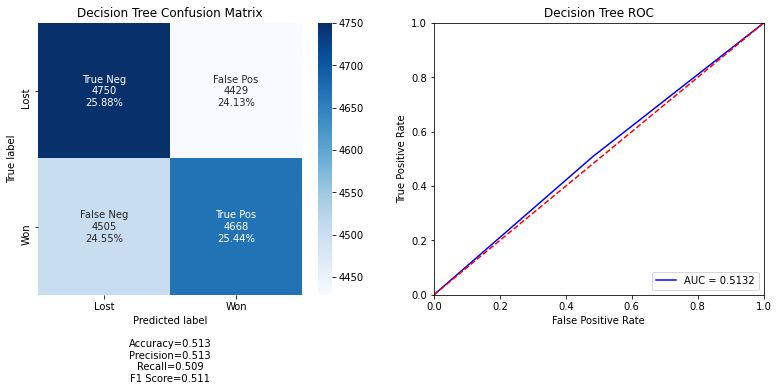

<Figure size 432x288 with 0 Axes>

In [58]:
validate_model(dtc, feat, label, 'Decision Tree', group_names=group_names, categories=categories)

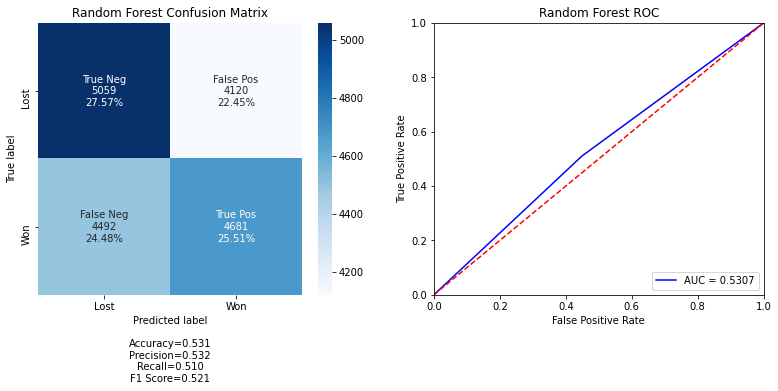

<Figure size 432x288 with 0 Axes>

In [59]:
validate_model(rfc, feat, label, 'Random Forest', group_names=group_names, categories=categories)

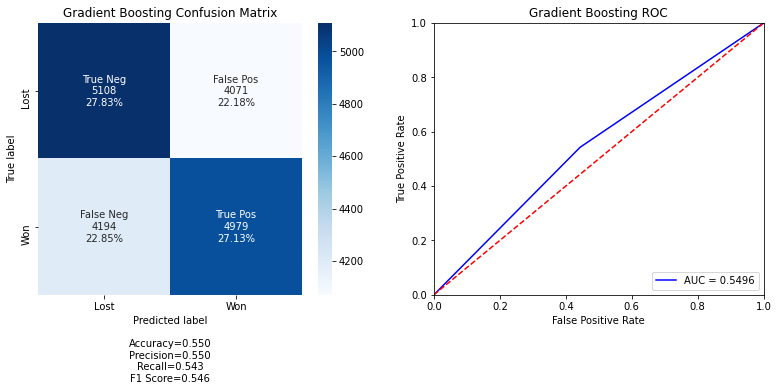

<Figure size 432x288 with 0 Axes>

In [60]:
validate_model(gbc, feat, label, 'Gradient Boosting', group_names=group_names, categories=categories)

This leads me to believe that our new features have nearly-zero predictive power, but while we're here, let's see if tuning hyperparameters makes even the slightest difference

In [61]:
from sklearn.model_selection import GridSearchCV

selected_model = gbc = GradientBoostingClassifier(min_samples_split=500, min_samples_leaf=50, max_depth=8, max_features='sqrt', subsample=0.8, random_state=10)

n_trees_search = GridSearchCV(estimator=selected_model, param_grid={'n_estimators':range(20,101,10)}, scoring='roc_auc', n_jobs=4, cv=5)
n_trees_search.fit(feat, label)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(20, 101, 10)},
             scoring='roc_auc')

In [62]:
n_trees = n_trees_search.best_params_['n_estimators']

In [63]:
refined_gbc = GradientBoostingClassifier(min_samples_leaf=50, n_estimators=n_trees, max_features='sqrt', subsample=0.8, random_state=10)
depth_split_grid = {'max_depth': range(5,16,2), 'min_samples_split': range(200,1601,200)}
depth_split_test = GridSearchCV(estimator=refined_gbc , param_grid=depth_split_grid, scoring='roc_auc' ,n_jobs=-1, cv=5)
depth_split_test.fit(feat, label)
depth = depth_split_test.best_params_['max_depth']
split = depth_split_test.best_params_['min_samples_split']

In [64]:
refined_gbc = GradientBoostingClassifier(n_estimators=n_trees, min_samples_split=split, max_depth=depth, max_features='sqrt', subsample=0.8, random_state=10)
leaf_grid = {'min_samples_leaf':range(30,91,10)}
leaf_test = GridSearchCV(estimator=refined_gbc, param_grid=leaf_grid, scoring='roc_auc',n_jobs=-1,cv=5)
leaf_test.fit(feat,label)
leaf = leaf_test.best_params_['min_samples_leaf']

In [65]:
refined_gbc = GradientBoostingClassifier(n_estimators=n_trees, min_samples_split=split, max_depth=depth, min_samples_leaf=leaf, subsample=0.8, random_state=10)
features_grid = {'max_features':range(5,30,2)}
features_test = GridSearchCV(estimator=refined_gbc, param_grid=features_grid, scoring='roc_auc', n_jobs=-1, cv=5)
features_test.fit(feat, label)
features = features_test.best_params_['max_features']

In [66]:
refined_gbc = GradientBoostingClassifier(n_estimators=n_trees, min_samples_split=split, max_depth=depth, min_samples_leaf=leaf, max_features=features, random_state=10)
subsample_grid = {'subsample':[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]}
subsample_test = GridSearchCV(estimator=refined_gbc, param_grid=subsample_grid, scoring='roc_auc', n_jobs=-1, cv=5)
subsample_test.fit(feat,label)
subsample = subsample_test.best_params_['subsample']

In [67]:
tuned_model = GradientBoostingClassifier(learning_rate=0.001,n_estimators=100*n_trees, min_samples_split=split, max_depth=depth, min_samples_leaf=leaf, max_features=features, subsample=subsample, random_state=10)
validate_model(tuned_model, feat,label, 'Tuned Gradient Boosting Classifier', group_names=group_names, categories=categories)

Unfortunately, that's about as good as this approach is going to get

In [67]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
feat = new_df.drop(columns=['team','season','gameId','WON'])
label = new_df['WON']

lr2 = LogisticRegression()
scores = cross_val_score(lr2, feat, label, cv=50)
print(scores)

x_train,x_test,y_train,y_test = train_test_split(feat,label,test_size=0.2) # test on 30% of dataset 
y_train = y_train.astype('int')
y_test = y_test.astype('int')
lr2.fit(x_train,y_train)
pred = lr2.predict(x_test)
print(accuracy_score(y_test,pred))

[0.48641304 0.56793478 0.53678474 0.59673025 0.57493188 0.54768392
 0.52316076 0.58855586 0.55858311 0.55585831 0.5640327  0.57493188
 0.57765668 0.57765668 0.60217984 0.60490463 0.53405995 0.49318801
 0.52043597 0.60762943 0.55313351 0.52861035 0.53133515 0.53133515
 0.58038147 0.57493188 0.52861035 0.53678474 0.5613079  0.56675749
 0.52588556 0.49591281 0.59128065 0.59945504 0.55040872 0.49318801
 0.57765668 0.60490463 0.58855586 0.52043597 0.56675749 0.60217984
 0.53950954 0.60217984 0.58038147 0.52588556 0.5613079  0.49591281
 0.61580381 0.51498638]
0.5704167801688913


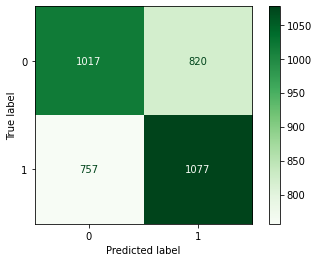

In [68]:
plot_confusion_matrix(lr2,x_test,y_test,cmap=plt.cm.Greens)

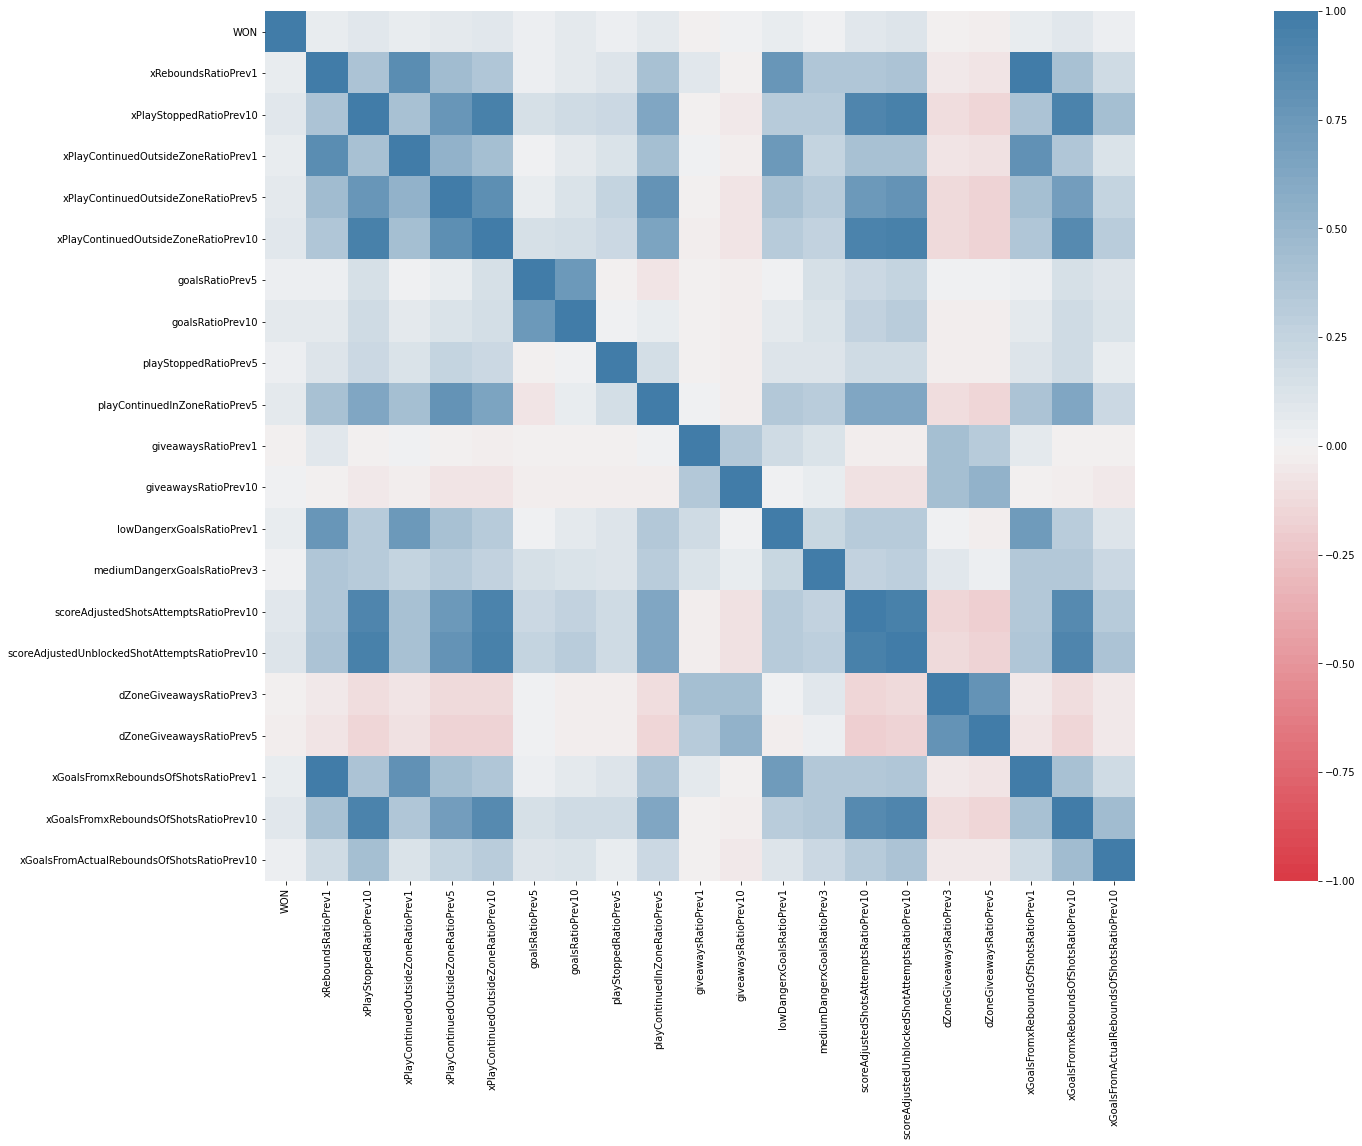

In [69]:
new_df.WON = new_df.WON.astype(int)
corr = new_df.drop(columns=['team','gameId','season']).corr()
fig, ax = plt.subplots(figsize=(50,16)) 
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1,
    square=True,
    cmap=sns.diverging_palette(10,240,n=100),
    ax=ax
)

In [70]:
corr.WON.sort_values(ascending=False)

WON                                              1.000000
scoreAdjustedUnblockedShotAttemptsRatioPrev10    0.100158
scoreAdjustedShotsAttemptsRatioPrev10            0.095807
xPlayContinuedOutsideZoneRatioPrev10             0.092998
xPlayStoppedRatioPrev10                          0.083990
xGoalsFromxReboundsOfShotsRatioPrev10            0.083389
xPlayContinuedOutsideZoneRatioPrev5              0.075792
playContinuedInZoneRatioPrev5                    0.068098
goalsRatioPrev10                                 0.066889
xReboundsRatioPrev1                              0.051056
lowDangerxGoalsRatioPrev1                        0.051013
xGoalsFromxReboundsOfShotsRatioPrev1             0.049764
xPlayContinuedOutsideZoneRatioPrev1              0.046285
goalsRatioPrev5                                  0.038199
xGoalsFromActualReboundsOfShotsRatioPrev10       0.035494
playStoppedRatioPrev5                            0.025007
mediumDangerxGoalsRatioPrev3                     0.016636
giveawaysRatio

In [71]:
corr.describe()

,WON,xReboundsRatioPrev1,xPlayStoppedRatioPrev10,xPlayContinuedOutsideZoneRatioPrev1,xPlayContinuedOutsideZoneRatioPrev5,xPlayContinuedOutsideZoneRatioPrev10,goalsRatioPrev5,goalsRatioPrev10,playStoppedRatioPrev5,playContinuedInZoneRatioPrev5,...,giveawaysRatioPrev10,lowDangerxGoalsRatioPrev1,mediumDangerxGoalsRatioPrev3,scoreAdjustedShotsAttemptsRatioPrev10,scoreAdjustedUnblockedShotAttemptsRatioPrev10,dZoneGiveawaysRatioPrev3,dZoneGiveawaysRatioPrev5,xGoalsFromxReboundsOfShotsRatioPrev1,xGoalsFromxReboundsOfShotsRatioPrev10,xGoalsFromActualReboundsOfShotsRatioPrev10
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,...,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,0.092714,0.343637,0.416113,0.326683,0.389901,0.403464,0.142211,0.170596,0.141255,0.330122,...,0.084191,0.304681,0.250764,0.401684,0.420847,0.075359,0.055088,0.332692,0.408038,0.208271
std,0.210991,0.326670,0.381712,0.325967,0.356041,0.385300,0.259181,0.254178,0.217469,0.328604,...,0.271904,0.289655,0.206385,0.379489,0.385769,0.315563,0.328225,0.324082,0.366694,0.237323
min,-0.024027,-0.068021,-0.149516,-0.092691,-0.160133,-0.161966,-0.068760,-0.028832,-0.035840,-0.151504,...,-0.090673,-0.031298,0.016636,-0.180263,-0.171916,-0.141801,-0.180263,-0.073114,-0.141728,-0.052070
25%,0.025007,0.075028,0.145538,0.046285,0.075792,0.142771,0.007917,0.043901,0.006447,0.043901,...,-0.043711,0.061185,0.120745,0.189592,0.197769,-0.115001,-0.149516,0.067560,0.148265,0.053559
50%,0.051013,0.373915,0.389939,0.377112,0.401875,0.332953,0.039544,0.075028,0.114852,0.357672,...,-0.027258,0.317760,0.257928,0.339301,0.379245,-0.043811,-0.052070,0.359933,0.377112,0.184635
75%,0.083389,0.414118,0.772959,0.435685,0.756933,0.822126,0.145538,0.181533,0.189592,0.630020,...,0.018052,0.357672,0.320958,0.756933,0.786089,0.007917,0.000957,0.413547,0.710940,0.313926
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Combining opponent data

To this point, we have only been considering information from one of the two teams in each game. By combining the features of both teams to each gameId, we will be able to feed our model much more information.

In [72]:
# Separate training and testing datasets for ease of use later
df_train = new_df.loc[new_df.season < 2018]
df_test = new_df.loc[new_df.season == 2018]

In [73]:
# Define function for merging the features of both opponents for each game ID
# We must make sure to keep a 50/50 split for our label so our model doesn't get biased towards one outcome
def merge_opponents(df):
    # Get all the winning teams for each game
    wins = df.loc[df.WON == 1]
    wins_index = wins.index.tolist()
    # Devide into 2
    half_of_wins = wins.iloc[:int(len(wins_index)/2), :]
    # find the losing teams corresponding to the first half of the games
    corresponding_games = df.loc[df.gameId.isin(half_of_wins.gameId.values.tolist())]
    corresponding_losses = corresponding_games.drop(corresponding_games.loc[corresponding_games.WON == 1].index)
    # Get the wins and losses for the other half of games
    other_games = df.loc[~df.gameId.isin(half_of_wins.gameId.values.tolist())]
    other_wins = other_games[other_games.WON == 1]
    other_losses = other_games[other_games.WON == 0]
    # Append opposing teams to the same row
    # The games are spit in two so that half of the resulting rows represent "wins" and the other half represent "losses"
    for col in df.columns:
        if col != 'gameId':
            corresponding_losses.rename(columns={col: f"opp_{col}"}, inplace=True)
            other_wins.rename(columns={col: f"opp_{col}"}, inplace=True)
    # combine to give merged dataframe
    first_half = pd.merge(half_of_wins, corresponding_losses, how='inner', on='gameId')
    second_half = pd.merge(other_losses, other_wins, how='inner', on='gameId')
    merged_df = pd.concat([first_half, second_half])
    return merged_df

In [74]:
# Merge opponents for our train and test dataframes
df_train = merge_opponents(df_train)
df_test = merge_opponents(df_test)
df_test

,team,home_or_away,gameId,season,WON,xReboundsRatioPrev1,xPlayStoppedRatioPrev10,xPlayContinuedOutsideZoneRatioPrev1,xPlayContinuedOutsideZoneRatioPrev5,xPlayContinuedOutsideZoneRatioPrev10,...,opp_giveawaysRatioPrev10,opp_lowDangerxGoalsRatioPrev1,opp_mediumDangerxGoalsRatioPrev3,opp_scoreAdjustedShotsAttemptsRatioPrev10,opp_scoreAdjustedUnblockedShotAttemptsRatioPrev10,opp_dZoneGiveawaysRatioPrev3,opp_dZoneGiveawaysRatioPrev5,opp_xGoalsFromxReboundsOfShotsRatioPrev1,opp_xGoalsFromxReboundsOfShotsRatioPrev10,opp_xGoalsFromActualReboundsOfShotsRatioPrev10
0,ANA,1,2018020209,2018,1,0.576972,0.166723,0.485940,0.372550,0.237426,...,0.403743,0.447187,0.518228,0.536660,0.531454,0.406536,0.488315,0.431134,0.510781,0.369778
1,ANA,1,2018020226,2018,1,0.581998,0.253615,0.559992,0.517647,0.324648,...,0.548371,0.732628,0.675652,0.678911,0.586681,0.497354,0.442220,0.793946,0.551935,0.379642
2,ANA,1,2018020263,2018,1,0.235217,0.267067,0.360034,0.473470,0.339281,...,0.434815,0.459865,0.299306,0.644485,0.609146,0.378205,0.418426,0.668644,0.514935,0.517458
3,ANA,1,2018020330,2018,1,0.445734,0.451303,0.399824,0.491271,0.483093,...,0.506120,0.438825,0.491106,0.528116,0.503590,0.487302,0.414152,0.291692,0.413384,0.411263
4,ANA,1,2018020337,2018,1,0.621220,0.462389,0.443190,0.517777,0.473486,...,0.555746,0.436896,0.575011,0.599806,0.544482,0.558730,0.574838,0.375020,0.472207,0.383147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,WSH,0,2018020765,2018,0,0.426076,0.450317,0.413634,0.484419,0.494545,...,0.595643,0.742276,0.390174,0.631229,0.537890,0.462302,0.477342,0.500000,0.534638,0.651041
548,WSH,0,2018021073,2018,0,0.304727,0.630096,0.270121,0.648106,0.613283,...,0.422388,0.490488,0.604125,0.566811,0.564346,0.690476,0.626583,0.452271,0.426099,0.541148
549,WSH,0,2018021105,2018,0,0.575823,0.714867,0.613357,0.635325,0.691964,...,0.602079,0.731002,0.694231,0.702083,0.687054,0.263889,0.321657,0.652013,0.538500,0.612382
550,WSH,1,2018021133,2018,0,0.501870,0.728422,0.575904,0.611486,0.729257,...,0.609665,0.359919,0.510260,0.631057,0.604301,0.458333,0.367528,0.284045,0.434834,0.585038


In [75]:
# Drop the metadata and opponent labels
df_train.drop(columns=['team','opp_team','opp_WON','gameId','opp_home_or_away','opp_season','season'], inplace=True)
df_test.drop(columns=['team','opp_team','opp_WON','gameId','opp_home_or_away','opp_season','season'], inplace=True)
# create our training and testing vectors
x_train = df_train.drop(columns=['WON'])
x_test = df_test.drop(columns=['WON'])
y_train = df_train['WON']
y_test = df_test['WON']
# ensure the datatypes are correct
y_train = y_train.astype('int')
y_test = y_test.astype('int')


In [76]:
x_train.home_or_away = x_train.home_or_away.astype('int')
x_test.home_or_away = x_test.home_or_away.astype('int')

In [77]:
# Train a logistic regression model using the features from both teams
lr2 = LogisticRegression()
lr2.fit(x_train,y_train)
pred = lr2.predict(x_test)
accuracy_score(y_test,pred)

0.5732368896925859

In [79]:
lrc = LogisticRegression()
knnc = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

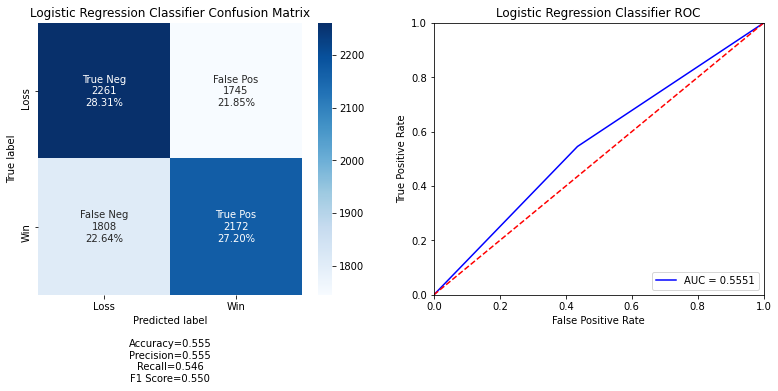

<Figure size 432x288 with 0 Axes>

In [80]:
validate_model(lrc, x_train, y_train, 'Logistic Regression Classifier', group_names=group_names, categories=categories)

In [81]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from train_xgboost import xgboost_modelfit

ModuleNotFoundError: No module named 'xgboost'

In [92]:
xgb1 = XGBClassifier(learning_rate=0.1, n_estimators=27, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

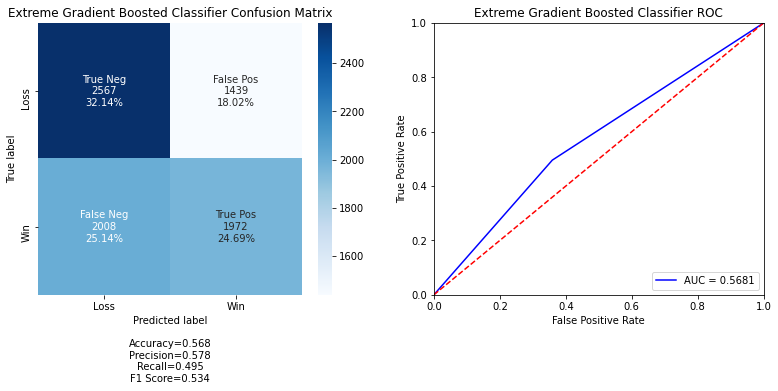

<Figure size 432x288 with 0 Axes>

In [93]:
validate_model(xgb1, x_train, y_train, 'Extreme Gradient Boosted Classifier', group_names=group_names, categories=categories)

Optimal number of estimators: 27

Model Report
Accuracy (Train): 0.7082
AUC Score (Train): 0.7764
Accuracy (Test): 0.5461
AUC Score (Test): 0.5703


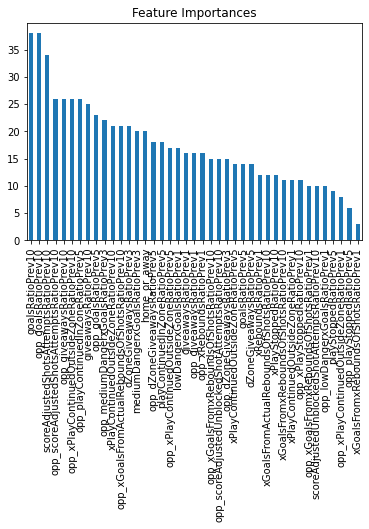

In [94]:
xgboost_modelfit(xgb1, x_train, y_train, x_test, y_test)